[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shhommychon/mnist_generative_practice/blob/master/VAE.ipynb)

# MNIST VAE 학습

## 환경설정

- PyTorch 버젼 다운그레이드 코드로 인해 세션이 자동으로 한번 꺼질 예정입니다. 다시 실행하면 됩니다.

In [1]:
# 현 CUDA 버젼 확인
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
# 파이썬 버젼 고정
import torch

# 현 PyTorch 버젼 확인
if torch.__version__.split('+')[0] != "1.11.0":
    print(f"Current PyTorch version is {torch.__version__}, downgrading to 1.11.0")

    # PyTorch 제거
    !pip uninstall torch torchvision -y

    # PyTorch 1.11.0 설치
    !pip install torch==1.11.0 torchvision==0.12.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

    # 런타임 강제 재시작
    import os
    os.kill(os.getpid(), 9)
else:
    print("PyTorch version is already 1.11.0")

PyTorch version is already 1.11.0


In [3]:
!git clone https://github.com/shhommychon/mnist_generative_practice.git

import sys
sys.path = ["./mnist_generative_practice"] + sys.path

Cloning into 'mnist_generative_practice'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16 (delta 4), reused 15 (delta 3), pack-reused 0
Receiving objects: 100% (16/16), 7.91 KiB | 7.91 MiB/s, done.
Resolving deltas: 100% (4/4), done.


## 실습 코드

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

### MNIST 데이터셋 다운로드 및 불러오기

- 다운로드 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#downloading-datasets)
- 불러오기 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#splitting-datasets)

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(
                                mnist_testset,
                                [
                                    int(0.9 * len(mnist_testset)),
                                    int(0.1 * len(mnist_testset))
                                ]
                            )
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


### 모델 및 손실함수/옵티마이저 등 설정

In [6]:
from models.vae import MNISTVae

model = MNISTVae()

if (torch.cuda.is_available()): model.cuda()

model

MNISTVae(
  (label_emb): Embedding(10, 16)
  (fc_mu): Linear(in_features=784, out_features=96, bias=True)
  (fc_logvar): Linear(in_features=784, out_features=96, bias=True)
  (linear): Linear(in_features=112, out_features=784, bias=True)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (tanh): Tanh()
)

In [7]:
def latent_loss(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence

pixelwise_loss = nn.L1Loss()

lr=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

decay_rate = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

max_epochs = 100
best_val_loss = 100
max_patience = 7

### 이미지 생성 코드

- 학습 중간 확인 용도

In [8]:
def generate_images(model, latent, class_label):
    model.eval()
    with torch.no_grad():
        latent = latent.to(device)
        class_label = class_label.to(device)
        images = model.decode(latent, class_label)
    return images

### 모델 학습 코드


Epoch: 1/100,
	Train Loss: 1.46340998
		kl divergence loss: 22.08931022
		pixelwise loss: 0.14413207
	Val Loss: 3.39232581
		kl divergence loss: 1060.21386165
		pixelwise loss: 0.23321119


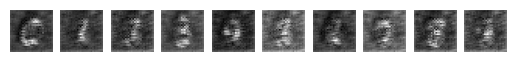

	Saving the model state dictionary for Epoch: 1 with Validation loss: 3.39232581

Epoch: 2/100,
	Train Loss: 3.14825614
		kl divergence loss: 1087.40036350
		pixelwise loss: 0.20608557
	Val Loss: 3.01052487
		kl divergence loss: 869.78038090
		pixelwise loss: 0.21407444


<Figure size 640x480 with 0 Axes>

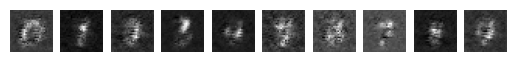

	Saving the model state dictionary for Epoch: 2 with Validation loss: 3.01052487

Epoch: 3/100,
	Train Loss: 3.52565149
		kl divergence loss: 1961.48489328
		pixelwise loss: 0.15641665
	Val Loss: 1.65591755
		kl divergence loss: 310.27524104
		pixelwise loss: 0.13456423


<Figure size 640x480 with 0 Axes>

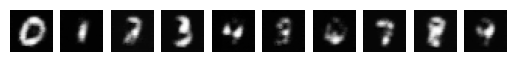

	Saving the model state dictionary for Epoch: 3 with Validation loss: 1.65591755

Epoch: 4/100,
	Train Loss: 1.79449025
		kl divergence loss: 593.19529417
		pixelwise loss: 0.12012949
	Val Loss: 1.22327472
		kl divergence loss: 91.45398928
		pixelwise loss: 0.11318207


<Figure size 640x480 with 0 Axes>

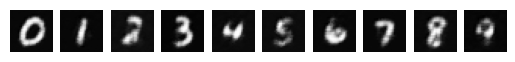

	Saving the model state dictionary for Epoch: 4 with Validation loss: 1.22327472

Epoch: 5/100,
	Train Loss: 1.28807663
		kl divergence loss: 197.27341390
		pixelwise loss: 0.10908032
	Val Loss: 1.15213023
		kl divergence loss: 78.76932093
		pixelwise loss: 0.10733609


<Figure size 640x480 with 0 Axes>

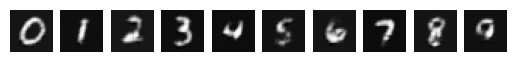

	Saving the model state dictionary for Epoch: 5 with Validation loss: 1.15213023

Epoch: 6/100,
	Train Loss: 1.20542153
		kl divergence loss: 115.48603851
		pixelwise loss: 0.10899355
	Val Loss: 1.15045549
		kl divergence loss: 99.82773467
		pixelwise loss: 0.10506277


<Figure size 640x480 with 0 Axes>

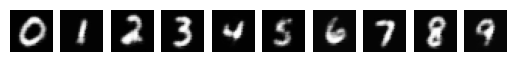

	Saving the model state dictionary for Epoch: 6 with Validation loss: 1.15045549

Epoch: 7/100,
	Train Loss: 1.21401589
		kl divergence loss: 182.14443771
		pixelwise loss: 0.10318714
	Val Loss: 1.29968573
		kl divergence loss: 269.04116686
		pixelwise loss: 0.10306446


<Figure size 640x480 with 0 Axes>

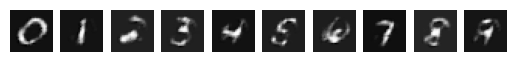

	Loss not decreased. Will wait for 6 more epochs...

Epoch: 8/100,
	Train Loss: 1.46337418
		kl divergence loss: 423.69370057
		pixelwise loss: 0.10396805
	Val Loss: 1.42998026
		kl divergence loss: 430.72508336
		pixelwise loss: 0.09992552


<Figure size 640x480 with 0 Axes>

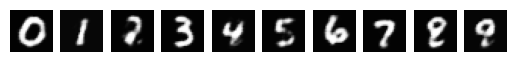

	Loss not decreased. Will wait for 5 more epochs...

Epoch: 9/100,
	Train Loss: 1.68745277
		kl divergence loss: 699.46330729
		pixelwise loss: 0.09879894
	Val Loss: 1.13445927
		kl divergence loss: 188.02878780
		pixelwise loss: 0.09464305


<Figure size 640x480 with 0 Axes>

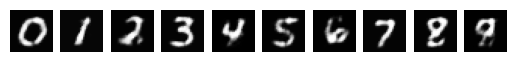

	Saving the model state dictionary for Epoch: 9 with Validation loss: 1.13445927

Epoch: 10/100,
	Train Loss: 1.26906962
		kl divergence loss: 340.68619458
		pixelwise loss: 0.09283834
	Val Loss: 1.22401838
		kl divergence loss: 287.64672811
		pixelwise loss: 0.09363716


<Figure size 640x480 with 0 Axes>

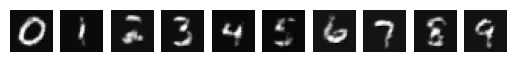

	Loss not decreased. Will wait for 6 more epochs...

Epoch: 11/100,
	Train Loss: 1.47322324
		kl divergence loss: 498.38476610
		pixelwise loss: 0.09748385
	Val Loss: 1.27317063
		kl divergence loss: 327.36961052
		pixelwise loss: 0.09458010


<Figure size 640x480 with 0 Axes>

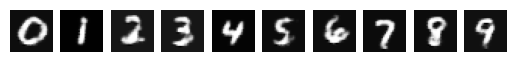

	Loss not decreased. Will wait for 5 more epochs...

Epoch: 12/100,
	Train Loss: 1.46004101
		kl divergence loss: 529.84411709
		pixelwise loss: 0.09301969
	Val Loss: 1.14875464
		kl divergence loss: 230.57216452
		pixelwise loss: 0.09181825


<Figure size 640x480 with 0 Axes>

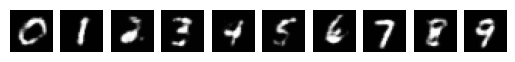

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 13/100,
	Train Loss: 1.38570752
		kl divergence loss: 420.71818850
		pixelwise loss: 0.09649893
	Val Loss: 1.18457614
		kl divergence loss: 262.20983411
		pixelwise loss: 0.09223663


<Figure size 640x480 with 0 Axes>

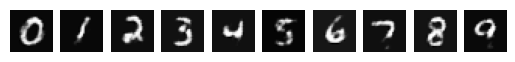

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 14/100,
	Train Loss: 1.45759875
		kl divergence loss: 544.00348480
		pixelwise loss: 0.09135952
	Val Loss: 1.18710520
		kl divergence loss: 276.00636402
		pixelwise loss: 0.09110988


<Figure size 640x480 with 0 Axes>

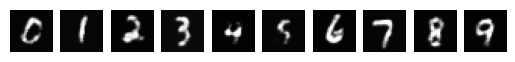

	Loss not decreased. Will wait for 2 more epochs...

Epoch: 15/100,
	Train Loss: 1.37444947
		kl divergence loss: 461.05554254
		pixelwise loss: 0.09133939
	Val Loss: 1.18533202
		kl divergence loss: 287.10846767
		pixelwise loss: 0.08982235


<Figure size 640x480 with 0 Axes>

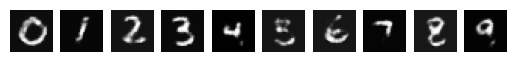

	Loss not decreased. Will wait for 1 more epochs...

Epoch: 16/100,
	Train Loss: 1.46561527
		kl divergence loss: 568.15025863
		pixelwise loss: 0.08974650
	Val Loss: 1.18708955
		kl divergence loss: 284.56090911
		pixelwise loss: 0.09025286


<Figure size 640x480 with 0 Axes>

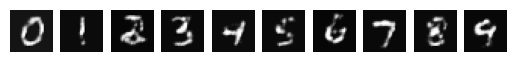

	Loss not decreased. Will wait for 0 more epochs...


<Figure size 640x480 with 0 Axes>

In [9]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"
patience = max_patience
for epoch in range(max_epochs):
    total_train_loss = {
        "loss_kldiv": 0,
        "loss_pixel": 0,
        "loss_total": 0,
    }
    total_val_loss = {
        "loss_kldiv": 0,
        "loss_pixel": 0,
        "loss_total": 0,
    }

    model.train()

    # training
    for iter, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.to(device)

        # optimizing gradients to zero before training
        optimizer.zero_grad()

        recon_image, mu, logvar = model(image, label)

        ## latent loss
        train_loss_kldiv = latent_loss(mu, logvar)

        ## reconstruction loss
        train_loss_pixel = pixelwise_loss(recon_image, image)

        # Update the autoencoder weights
        this_train_loss = 0.001 * train_loss_kldiv + 10 * train_loss_pixel
        this_train_loss.backward()
        optimizer.step()


        total_train_loss["loss_kldiv"] += train_loss_kldiv.item()
        total_train_loss["loss_pixel"] += train_loss_pixel.item()
        total_train_loss["loss_total"] += this_train_loss.item()

    # Step the learning rate schedulers
    scheduler.step()

    total_train_loss = { k: train_loss / (iter + 1) for k, train_loss
                                                in total_train_loss.items() }

    # validation
    model.eval()

    for iter, (image, label) in enumerate(val_dataloader):
        image = image.to(device)
        label = label.to(device)

        recon_image, mu, logvar = model(image, label)

        ## latent loss
        val_loss_kldiv = latent_loss(mu, logvar)

        ## reconstruction loss
        val_loss_pixel = pixelwise_loss(recon_image, image)

        # Update the autoencoder weights
        this_val_loss = 0.001 * val_loss_kldiv + 10 * val_loss_pixel
        this_val_loss.backward()
        optimizer.step()


        total_val_loss["loss_kldiv"] += val_loss_kldiv.item()
        total_val_loss["loss_pixel"] += val_loss_pixel.item()
        total_val_loss["loss_total"] += this_val_loss.item()

    total_val_loss = { k: val_loss / (iter + 1) for k, val_loss
                                                in total_val_loss.items() }

    print(f"\nEpoch: {epoch+1}/{max_epochs},"
          f"\n\tTrain Loss: {total_train_loss['loss_total']:.8f}"
          f"\n\t\tkl divergence loss: {total_train_loss['loss_kldiv']:.8f}"
          f"\n\t\tpixelwise loss: {total_train_loss['loss_pixel']:.8f}"
          f"\n\tVal Loss: {total_val_loss['loss_total']:.8f}"
          f"\n\t\tkl divergence loss: {total_val_loss['loss_kldiv']:.8f}"
          f"\n\t\tpixelwise loss: {total_val_loss['loss_pixel']:.8f}")

    z_noise = torch.randn(1, 96).repeat(10, 1)
    class_label = torch.tensor([ n for n in range(10) ])
    result = generate_images(model, z_noise, class_label).cpu().detach().numpy()

    fig, ax = plt.subplots(nrows=1, ncols=10)
    for i, image in enumerate(result):
        plt.subplot(1, 10, i+1)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()
    plt.clf()

    if total_val_loss["loss_total"] < best_val_loss:
        best_val_loss = total_val_loss["loss_total"]
        print(f"\tSaving the model state dictionary for Epoch: {epoch+1} with Validation loss: {best_val_loss:.8f}")
        torch.save(model.state_dict(), "mnist_vae.dth")
        patience = max_patience
    else:
        patience -= 1
        print(f"\tLoss not decreased. Will wait for {patience} more epochs...")

    if patience <= 0: break


### 사전학습 모델 불러오기

- 위 모델 학습 코드를 실행하기 귀찮을 경우에만 이 셀을 실행

In [9]:
!apt install megatools

# mnist_vae.dth
!megadl 'https://mega.nz/file/PoUSCLgK#xjyW2dyY_TbrztxZhB97ssCnY48zBHv9GYiaMnx3sgc'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 0s (541 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 121671 files and directories currently installed.)
Preparing to unpack .../megatools_1.10.3-1build1_amd64.deb ...
Unpacking megatools (1.10.3-1build1) ...
Setting up megatools (1.10.3-1build1) ...
Processing triggers for man-db (2.10.2-1) ...
Downloaded mnist_vae.dth


### 학습 모델 테스트

In [10]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"

model = MNISTVae()
model.load_state_dict(torch.load("mnist_vae.dth"))

if (torch.cuda.is_available()): model.cuda()

model.eval()

MNISTVae(
  (label_emb): Embedding(10, 16)
  (fc_mu): Linear(in_features=784, out_features=96, bias=True)
  (fc_logvar): Linear(in_features=784, out_features=96, bias=True)
  (linear): Linear(in_features=112, out_features=784, bias=True)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (tanh): Tanh()
)

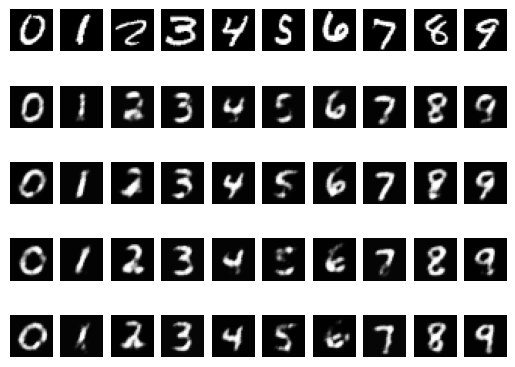

In [11]:
# MNIST 데이터셋 실제 샘플들 및 생성 결과들 저장

original = [ None for _ in range(10) ]

# store original image examples
stop = False
for iter, (image_batch, label_batch) in enumerate(test_dataloader):
    for image, label in zip(image_batch, label_batch):

        label = label.item()

        if original[label] is None:
            original[label] = image.data

        if None not in original:
            stop = True
            break

    if stop: break

z_noise = torch.randn(1, 96).repeat(10, 1) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ])
result1 = generate_images(model, z_noise, class_label).cpu().detach().numpy() # from noise 1

z_noise = torch.randn(1, 96).repeat(10, 1) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ])
result2 = generate_images(model, z_noise, class_label).cpu().detach().numpy() # from noise 2

z_noise = torch.randn(1, 96).repeat(10, 1) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ])
result3 = generate_images(model, z_noise, class_label).cpu().detach().numpy() # from noise 3

z_noise = torch.randn(1, 96).repeat(10, 1) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ])
result4 = generate_images(model, z_noise, class_label).cpu().detach().numpy() # from noise 4


# MNIST 데이터셋 실제 샘플들 및 생성 결과들 시각화

image_dim=28
fig, ax = plt.subplots(nrows=5, ncols=10)

for i, image in enumerate(original):
    plt.subplot(5, 10, 1*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result1):
    plt.subplot(5, 10, 2*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result2):
    plt.subplot(5, 10, 3*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result3):
    plt.subplot(5, 10, 4*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result4):
    plt.subplot(5, 10, 5*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

plt.show()